In [2]:
from dotenv import load_dotenv
import os
import yaml
from langchain_google_genai import GoogleGenerativeAIEmbeddings, GoogleGenerativeAI

In [103]:
# https://mirror-feeling-d80.notion.site/Workflow-And-Agents-17e808527b1780d792a0d934ce62bee6
# https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent

## setting up envs

In [4]:
env_path = r"D:\common_credentials\.env"
load_dotenv(dotenv_path=env_path)

# GROQ_API_KEY = os.getenv('GROQ_API_KEY')
# GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
# GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
# os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY
# os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"]="true"
# os.environ["LANGSMITH_PROJECT"]=os.getenv("LANGSMITH_PROJECT")
# os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGSMITH_PROJECT")
# os.environ["LANGSMITH_ENDPOINT"]=os.getenv("LANGSMITH_ENDPOINT")

True

## models config: with providers info

In [5]:
with open("../config.yml", "r") as yml_file:
    yml_config= yaml.safe_load(yml_file)
    yml_file.close()
yml_config

{'googleModels': {'Embedding_models': ['models/embedding-001',
   'models/text-embedding-004'],
  'Inferencing_Models': {'text_models': ['gemini-pro'],
   'multimodels': ['gemini-2.0-flash-exp',
    'gemini-1.5-flash',
    'gemini-1.5-flash-8b']}},
 'GroqModels': {'Inferencing_Models': {'multimodels': ['llama-3.2-90b-vision-preview',
    'llama-3.2-11b-vision-preview'],
   'reasoning_Models': ['deepseek-r1-distill-llama-70b'],
   'text_models': ['distil-whisper-large-v3-en',
    'gemma2-9b-it',
    'llama-3.3-70b-versatile',
    'llama-3.1-8b-instant',
    'whisper-large-v3-turbo',
    'deepseek-r1-distill-llama-70b']}}}

## Workflows
    - In past days; we used to take the output from llm & embed them to the some kind of predefined code
    - Agents: remove the scafholdings, let llm to ke take  direct own actions, it uses tools & decide what to do next
    - Langgraph Gives you lower level infrastructure using which you can design any workflow

pydantic: https://www.youtube.com/watch?v=XIdQ6gO3Anc

In [45]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from typing_extensions import TypedDict, Any, List
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq

In [19]:
llm = ChatGroq(model="llama-3.3-70b-versatile")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000212C6F9E090>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000212C6FBF490>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Pydantic Basics

In [32]:
#strict the model output
class Variables_type_tracker(BaseModel):
    name: str

a = Variables_type_tracker(name="Shubham")
a.name

'Shubham'

In [55]:
from pydantic import BaseModel, Field, validator, field_validator
class User(BaseModel):
    name: str
    age: int
    account_type: Any
    account_id: int

    @field_validator("account_id")
    def validae_account_id(cls, value):
        if value < 0:
            raise ValueError(f"account_id must be positive:{value}")
        return value

## how to feed data 
shubham = User(name="Shubham", age=1000, account_type={}, account_id= 70)

## another way using dict
user_data= {
    'name': "shubham",
    'age': 10000,
    'account_type': "Platinum",
    'account_id': 80
}

shubham2= User(**user_data)

## get  the variables
shubham2.name


'shubham'

In [57]:
## try to give negative value
user_data= {
    'name': "shubham",
    'age': 10000,
    'account_type': "Platinum",
    'account_id': -10
}
shubham2= User(**user_data)

ValidationError: 1 validation error for User
account_id
  Value error, account_id must be positive:-10 [type=value_error, input_value=-10, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

## graphs

In [80]:
from pydantic import BaseModel, Field

class search_query(BaseModel):
    search_query: str= Field(None, description="Query that is optimized the web search")
    justification:str= Field(None, description="Why this Query is relevant to the user's request")

#Agument llm with the schema
structured_llm= llm.with_structured_output(search_query)
response= structured_llm.invoke("How does the high cholesterol related to heart disease")
print("response : ", response)
print("response.search_query: ", response.search_query)
print("response.justification:", response.justification)


response :  search_query='high cholesterol and heart disease relationship' justification='The user is asking about the relationship between high cholesterol and heart disease, so a search query is needed to provide information on this topic.'
response.search_query:  high cholesterol and heart disease relationship
response.justification: The user is asking about the relationship between high cholesterol and heart disease, so a search query is needed to provide information on this topic.


In [81]:
##Define the tool
def multiply(a:int, b:int) -> int:
    return a * b

#binf the tool with llm
llm_with_bind_tools= llm.bind_tools([multiply])
msg= llm_with_bind_tools.invoke("What is 3 times 4?")
print("\nmsg: ", msg)
print("\nmsg.tool_calls: ", msg.tool_calls)


msg:  content='' additional_kwargs={'tool_calls': [{'id': 'call_hn16', 'function': {'arguments': '{"a": 3, "b": 4}', 'name': 'multiply'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 212, 'total_tokens': 231, 'completion_time': 0.069090909, 'prompt_time': 0.02994347, 'queue_time': 0.22436370800000002, 'total_time': 0.099034379}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-f1928983-a9f7-4374-b28b-35e474851605-0' tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 4}, 'id': 'call_hn16', 'type': 'tool_call'}] usage_metadata={'input_tokens': 212, 'output_tokens': 19, 'total_tokens': 231}

msg.tool_calls:  [{'name': 'multiply', 'args': {'a': 3, 'b': 4}, 'id': 'call_hn16', 'type': 'tool_call'}]


## prompt chaining

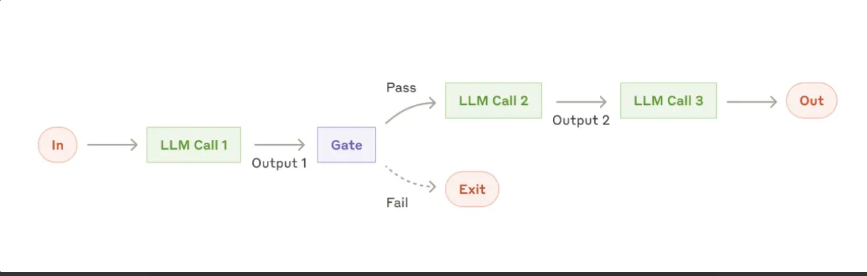

Each LLM call processes the output of the previous one:

- E.g., when decomposing a task into multiple LLM calls has benefit.

Example:

- Take a topic, LLM makes a joke, check the joke, improve it twice

In [83]:
#create the Grpah state
#create nodes for each task
#use validation node
#creat the chain 
#Display the graph
#run the chain

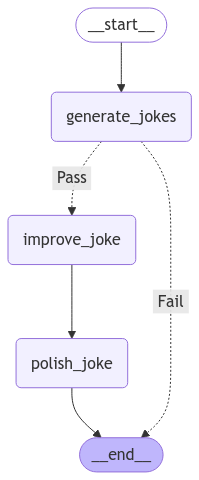

In [99]:
from langgraph.graph import Graph, StateGraph, START, END
from typing import  TypedDict

#Graph state
class State(TypedDict):
    topic:str
    joke:str
    improved_joke:str
    final_joke:str

#create the nodes

def generate_joke(state: State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state:State):
    """Second llm call in where it'll modify the basic joke"""
    msg= llm.invoke(f"Make this joke more funnier :{state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state:State):
    """Finally it will polish the joke"""
    msg= llm.invoke(f"polish this joke & add surprising indian twist:{state['improved_joke']}")
    return {"final_joke": msg.content}

#validation node
def validation_node(state:State):
    """It'll validate the joke after first call"""
    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

#creat the workflow
workflow= StateGraph(State)
workflow.add_node("generate_jokes", generate_jokes)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)
#add conditional edge
workflow.add_edge(START, "generate_jokes")
workflow.add_conditional_edges(
    "generate_jokes", validation_node,
    {"Pass": "improve_joke",
    "Fail": END}

)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

#compile the graph
chain= workflow.compile()

#Display the workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [100]:
satechain.invoke({"topic": "cats"})

{'topic': 'cats',
 'joke': 'Why did the cat join a band? Because it wanted to be the purr-cussionist.',
 'improved_joke': 'Here\'s a revised version with an added punchline:\n\nWhy did the cat join a band? Because it wanted to be the purr-cussionist. And now it\'s the cat\'s meow of the music scene – every time it plays a solo, the crowd goes wild and starts paw-ting along!\n\nI added a few cat-related puns to make the joke more playful and humorous. The phrase "cat\'s meow" is a common idiom that means something is excellent or of high quality, and "paw-ting" is a pun on "tapping" that incorporates the idea of paws. These additions add to the lighthearted and silly tone of the joke, making it more likely to elicit a laugh.',
 'final_joke': 'Here\'s a polished version with a surprising Indian twist:\n\nWhy did the cat join a Bollywood band? Because it wanted to be the purr-cussionist and add some mew-sical flair to the tabla beats! And now it\'s the cat\'s meow of the music scene – eve

In [102]:
# Invoke
state = chain.invoke({"topic": "Google"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did Google go to therapy? 
It had too many search issues.

--- --- ---

Improved joke:
A great starting point. Here are a few variations to make it even funnier:

1. Why did Google go to therapy? It had too many search issues and was feeling a little "dis-connected"!
2. Why did Google go to therapy? It was struggling to "find" itself and had too many search issues!
3. Why did Google go to therapy? It had too many search issues and was tired of being "redirected" to its problems!
4. Why did Google go to therapy? It had too many search issues and was feeling "lost" in cyberspace!
5. Why did Google go to therapy? It had too many search issues and was trying to "cache" its emotions!

Choose the one that makes you laugh the most, or feel free to modify them to create your own hilarious version!

--- --- ---

Final joke:
Here are some polished versions with a surprising Indian twist:

1. Why did Google go to an Ayurvedic therapist in India? It had too many search issues and

In [1]:
# from deepeval.benchmarks import MMLU
# from deepeval.benchmarks.mmlu.task import MMLUTask

# # Define benchmark with specific tasks and shots
# benchmark = MMLU(
#     tasks=[MMLUTask.HIGH_SCHOOL_COMPUTER_SCIENCE, MMLUTask.ASTRONOMY],
#     n_shots=3
# )

# # Replace 'mistral_7b' with your own custom model
# benchmark.evaluate(model=llm)
# print(benchmark.overall_score)